In [19]:
from google.colab import files
uploaded = files.upload()  # pick your JSON file
CONFIG_PATH = next(iter(uploaded))  # use the uploaded filename
print("Using:", CONFIG_PATH)


Saving sim-config.json to sim-config (2).json
Using: sim-config (2).json


In [20]:
#!pip install playwright
#!playwright install-deps chromium
#!python -m playwright install chromium


In [21]:
import json, pandas as pd, math
from playwright.async_api import async_playwright

In [22]:
URL = "https://basaga.org/basaga_files/partificial-life/index.html"
CONFIG_PATH = "config.json"
TIMEOUT_MS = 30000
NUM_SAMPLES = 1000
STEP_GAP = 1
CHUNK = 100

In [23]:
async def run_and_sample_progress(url, config_path, num_samples=1000, step_gap=1, timeout_ms=30000, chunk=100):
    cfg = json.load(open(config_path, "r", encoding="utf-8"))
    all_rows = []

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True, args=["--no-sandbox", "--disable-dev-shm-usage"])
        context = await browser.new_context()
        page = await context.new_page()

        await page.goto(url, wait_until="domcontentloaded")
        await page.wait_for_function("() => window.simAPI && typeof window.simAPI.start === 'function'", timeout=timeout_ms)

        await page.evaluate("cfg => window.simAPI.loadConfig(cfg)", cfg)
        await page.evaluate("() => { window.simAPI.reset(); window.simAPI.start(); }")

        batches = math.ceil(num_samples / chunk)
        for b in range(batches):
            take = min(chunk, num_samples - b*chunk)
            rows = await page.evaluate(
                """async ({n, gap}) => {
                    const out = [];
                    let target = (window.simAPI.getMetrics()?.step || 0);
                    for (let i = 0; i < n; i++) {
                        target += gap;
                        await window.simAPI.waitUntil(m => m.step >= target, { timeoutMs: 600000 });
                        const m = window.simAPI.getMetrics();
                        out.push([m.cluster, m.entropy, m.speed, m.change, m.cvi, m.step, performance.now()]);
                    }
                    return out;
                }""",
                {"n": take, "gap": step_gap}  # <-- pass as one object
            )
            all_rows.extend(rows)
            print(f"Collected {len(all_rows)} / {num_samples}")

        await browser.close()

    df = pd.DataFrame(all_rows, columns=["cluster","entropy","speed","change","cvi","step","t_ms"])
    df.to_csv("metrics_1000_samples.csv", index=False)
    print("Saved metrics_1000_samples.csv")
    return df

In [25]:
# Run it
df = await run_and_sample_progress(URL, CONFIG_PATH, NUM_SAMPLES, STEP_GAP, TIMEOUT_MS, CHUNK)
df.tail()

Collected 100 / 1000
Collected 200 / 1000
Collected 300 / 1000
Collected 400 / 1000
Collected 500 / 1000
Collected 600 / 1000
Collected 700 / 1000
Collected 800 / 1000
Collected 900 / 1000
Collected 1000 / 1000
Saved metrics_1000_samples.csv


,cluster,entropy,speed,change,cvi,step,t_ms
995,0.368,13.469689,0.158111,4.551069,0.065501,996,996998.1
996,0.372,13.489953,0.156408,4.695867,0.025720,997,998003.0
997,0.372,13.491290,0.156644,4.777920,0.007203,998,999000.2
998,0.376,13.451620,0.163197,5.044244,0.061285,999,1000030.4
999,0.372,13.460285,0.163326,4.461480,0.050030,1000,1001094.1


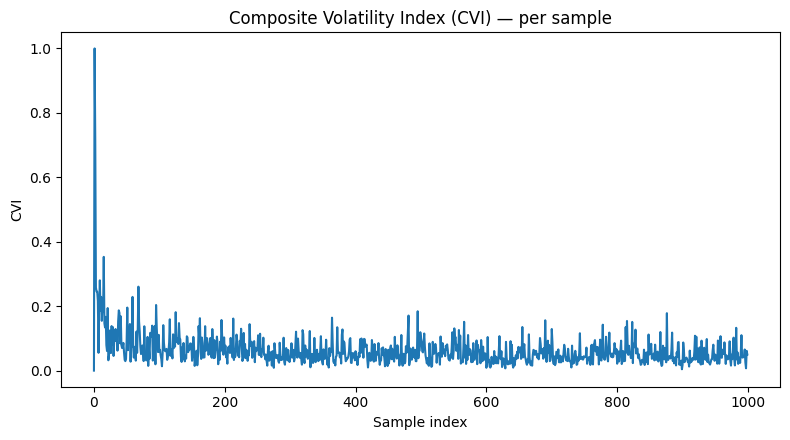

In [27]:
import matplotlib.pyplot as plt

data = df.copy()
cvi = data['cvi']
plt.figure(figsize=(8, 4.5))
plt.plot(cvi)  # no explicit colors/styles per your requirements
plt.title("Composite Volatility Index (CVI) — per sample")
plt.xlabel("Sample index")
plt.ylabel("CVI")
plt.tight_layout()

In [29]:
df.head(30)

,cluster,entropy,speed,change,cvi,step,t_ms
0,0.088,13.823248,0.140293,0.000000,0.000000,1,2042.0
1,0.080,13.826501,0.134825,3.210581,1.000000,2,3146.2
2,0.096,13.798962,0.133547,2.731157,0.717323,3,4147.8
3,0.092,13.785154,0.130654,2.576424,0.258066,4,5144.6
4,0.100,13.782424,0.127110,2.812419,0.245720,5,6133.0
5,0.116,13.773400,0.125680,2.610163,0.244927,6,7149.5
6,0.108,13.752928,0.120993,2.497633,0.216225,7,8131.6
7,0.108,13.747945,0.122615,2.389972,0.055251,8,9197.9
8,0.116,13.739118,0.127712,2.034299,0.188148,9,10178.1
9,0.132,13.727000,0.136195,2.376336,0.280206,10,11147.4


In [30]:
import time

# 1) Pick a filename (timestamped so you don't overwrite previous runs)
fname = f"metrics_{int(time.time())}.csv"

# 2) Save your DataFrame
df.to_csv(fname, index=False)
print("Saved:", fname)

# 3) Trigger a download (Colab)
from google.colab import files
files.download(fname)


Saved: metrics_1757104898.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>